In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv').to_numpy()
test = pd.read_csv('../input/digit-recognizer/test.csv').to_numpy()
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [3]:
SIZE = 28

BS = 64
EPOCHS = 25

SPLIT = 0.2

RANDOM_SEED = 17
LABELS = 10

set_seed(RANDOM_SEED)
seed(RANDOM_SEED)

In [4]:
train_X = train[:,1:]
train_Y = to_categorical(train[:,0])

train_X = np.reshape(train_X, (train_X.shape[0],28,28,1))
test_X = np.reshape(test, (test.shape[0],28,28,1))

train_X = train_X / 255.0
test_X = test_X / 255.0

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size = SPLIT,
                                                     stratify = train_Y, random_state = RANDOM_SEED)

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape, test_X.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10) (28000, 28, 28, 1)



#### Constants

#### Data generators

In [5]:
datagen = ImageDataGenerator(
        rotation_range = 45,
        width_shift_range = 2,
        height_shift_range = 2,
        zoom_range = 0.01)

train_gen = datagen.flow(
         train_X, train_Y,
         batch_size = BS,
         seed = RANDOM_SEED)

#### Build TensorFlow input pipelines

In [6]:
train = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None, SIZE, SIZE, 1], [None, LABELS]))

valid = tf.data.Dataset.from_tensor_slices((valid_X, valid_Y))

train = train.prefetch(AUTOTUNE).repeat()
valid = valid.batch(BS)

2022-03-23 05:51:41.209963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 05:51:41.305277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 05:51:41.306416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 05:51:41.309367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### Model

In [7]:
class CNN:
    @staticmethod
    def build(height, width, depth):
        model = keras.Sequential()
        
        model.add(Input((height, width, depth)))
        
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        
        return model

#### Build and compile model

In [8]:
model = CNN.build(SIZE, SIZE, 1)
model.summary()

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=5e-4,
    restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LR = LearningRateScheduler(scheduler)

model.compile(
    optimizer = 'SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    steps_per_execution = 8)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

#### Fit model

In [9]:
%%time
H = model.fit(
train, validation_data = valid,
epochs=EPOCHS,
steps_per_epoch = len(train_X) // BS,
callbacks = [early_stopping, LR])

Epoch 1/25


2022-03-23 05:51:44.048170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-23 05:51:45.927579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 19s 37ms/step - loss: 0.4025 - accuracy: 0.8879 - val_loss: 0.2365 - val_accuracy: 0.9667
Epoch 2/25
525/525 [==============================] - 11s 22ms/step - loss: 0.1455 - accuracy: 0.9593 - val_loss: 0.0785 - val_accuracy: 0.9763
Epoch 3/25
525/525 [==============================] - 12s 23ms/step - loss: 0.1049 - accuracy: 0.9697 - val_loss: 0.0729 - val_accuracy: 0.9774
Epoch 4/25
525/525 [==============================] - 12s 22ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 0.0500 - val_accuracy: 0.9838
Epoch 5/25
525/525 [==============================] - 11s 21ms/step - loss: 0.0793 - accuracy: 0.9767 - val_loss: 0.0475 - val_accuracy: 0.9856
Epoch 6/25
525/525 [==============================] - 12s 22ms/step - loss: 0.0684 - accuracy: 0.9796 - val_loss: 0.0476 - val_accuracy: 0.9843
Epoch 7/25
525/525 [==============================] - 11s 21ms/step - loss: 0.0620 - accuracy: 0.9815 - val_loss: 0.0393 - val_accuracy: 0.9880
Epo

#### Metrics

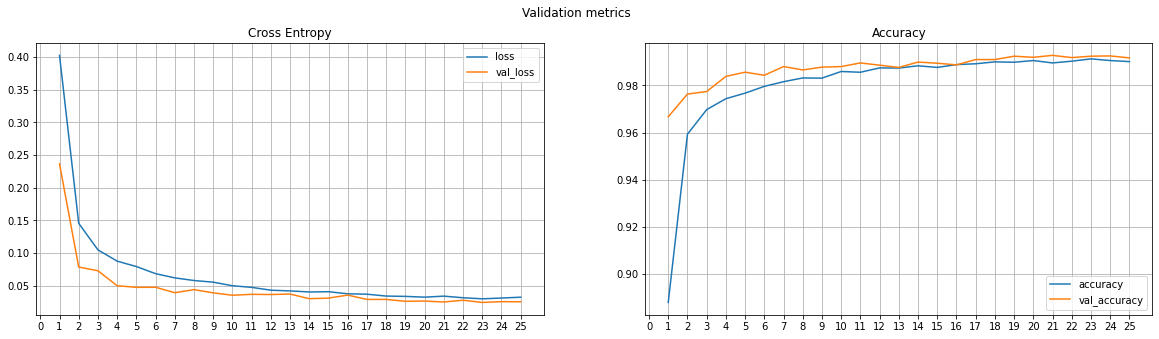

In [10]:
df = pd.DataFrame(H.history)
df.index += 1
fig = plt.figure(figsize = (20,5))
fig.suptitle('Validation metrics')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks(range(len(df)+1))
ax2.set_xticks(range(len(df)+1))
df[['loss', 'val_loss']].plot(title="Cross Entropy", grid=True, ax=ax1)
df[['accuracy', 'val_accuracy']].plot(title="Accuracy",grid=True, ax=ax2)
plt.show()

#### Model serialization

In [11]:
model.save('model.h5', save_format='h5')

#### Predictions

In [12]:
pred = model.predict(test_X)
classes = pred.argmax(axis=-1)

sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = classes
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


 #### Submission

In [13]:
sub.to_csv('submission.csv', index = False)

Model arhitecture taken from [**KASSEM Notebook**](https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook)